In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import time

import h5py
import librosa
import numpy as np

from utilities.utils import (create_folder, create_logging, read_metadata, pad_or_truncate)

In [3]:
DATA_FOLDER = "C:/Users/dhu/Downloads/birdsong-recognition"

TRAIN_METADATA_PATH = os.path.join("train_new.csv")
WAV_PATH = os.path.join(DATA_FOLDER, "dataset_wav/")
HDF5_PATH = os.path.join(DATA_FOLDER, "train_new.hdf5")

n_classes = 1
n_samples_per_class = 10
endpoint = n_classes * n_samples_per_class

meta_dict = read_metadata(TRAIN_METADATA_PATH)

In [20]:
def pack_waveforms_to_hdf5(audios_dir, csv_path, waveforms_hdf5_path, sample_rate, clip_length, starting_point=0, end_point=None):
    """Pack waveform and target of several audio clips to a single hdf5 file. 
    This can speed up loading and training.

    Parameters:
        audios_dir - Folder contains all .wav files.
        csv_path - The path to the metadata file.
        waveforms_hdf5_path - The path to the hdf5 filename to be stored.
        sample_rate - Sample rate when reading the waveform.
        clip_length - The maximum duration will be used for an audio clip.
        starting_point - The start index of reading the metadata.
        end_point - The end index of reading the metadata. If not set, all will be read.
    """
    logs_dir = '_logs/pack_waveforms_to_hdf5/{}'.format(os.path.basename(csv_path).split(".")[0])

    create_folder(logs_dir)
    create_logging(logs_dir, filemode='w')
    create_folder(os.path.dirname(waveforms_hdf5_path))

    logging.info('Write logs to {}'.format(logs_dir))
    
    meta_dict = read_metadata(csv_path)

    audios_num_total = len(meta_dict['audio_name'])
    clip_samples = clip_length * sample_rate

    # Pack waveform to hdf5
    total_time = time.time()

    with h5py.File(waveforms_hdf5_path, 'w') as hf:
        if not end_point:
            end_point = audios_num_total
        print("The range of samples: {} -> {}".format(starting_point, end_point))
        audios_num = end_point - starting_point

        if "waveform" not in hf.keys():
            hf.create_dataset('audio_name', shape=((audios_num_total,)), dtype='S20')
            hf.create_dataset('waveform', shape=((audios_num_total, clip_samples)), dtype=np.float32)
            hf.attrs.create('sample_rate', data=sample_rate, dtype=np.int32)

            hf['target'] = meta_dict['target'][starting_point:end_point]
            
        all_classes = meta_dict["bird_codes"][meta_dict['target'][starting_point:end_point]]

        # Pack waveform & target of several audio clips to a single hdf5 file
        for n in range(starting_point, end_point):
            audio_path = os.path.join(audios_dir, all_classes[n], meta_dict['audio_name'][n])

            if os.path.isfile(audio_path):
                logging.info('{} {}'.format(n, audio_path))
                (audio, _) = librosa.core.load(audio_path, sr=sample_rate, mono=True)
                audio = pad_or_truncate(audio, clip_samples)

                hf['audio_name'][n] = meta_dict['audio_name'][n].encode()
                hf['waveform'][n] = audio
            else:
                logging.info('{} File does not exist! {}'.format(n, audio_path))

    logging.info('Write to {}'.format(waveforms_hdf5_path))
    logging.info('Pack hdf5 time: {:.3f}'.format(time.time() - total_time))

    # # clean the file logger
    # logger = logging.getLogger('')
    # for h in logger.handlers:
    #     logger.removeHandler(h)
    # print(logger.handlers)

pack_waveforms_to_hdf5(WAV_PATH, TRAIN_METADATA_PATH, HDF5_PATH, sample_rate=32000, clip_length=100, end_point=endpoint)

root        : INFO     Write logs to _logs/pack_waveforms_to_hdf5/train_new
root        : INFO     Write logs to _logs/pack_waveforms_to_hdf5/train_new
root        : INFO     0 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC134874.wav
root        : INFO     0 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC134874.wav


The range of samples: 0 -> 10


root        : INFO     1 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135454.wav
root        : INFO     1 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135454.wav
root        : INFO     2 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135455.wav
root        : INFO     2 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135455.wav
root        : INFO     3 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135456.wav
root        : INFO     3 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135456.wav
root        : INFO     4 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135457.wav
root        : INFO     4 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135457.wav
root        : INFO     5 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC135459.wav
root        : INFO     5 C:/Users/dhu/Downloads/birdsong-recognition\dataset_wav/aldfly\XC1

[<StreamHandler stderr (INFO)>]


The hdf5 file C:/Users/dhu/Downloads/birdsong-recognition\train_new.hdf5 exists.
Shape (13200, 3200000)


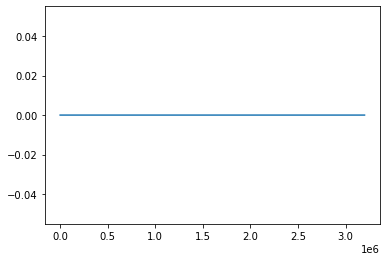

In [5]:
import matplotlib.pyplot as plt

print("The hdf5 file {} {}.".format(HDF5_PATH, "exists" if os.path.exists(HDF5_PATH) else "does not exist"))

with h5py.File(HDF5_PATH, 'r') as hf:
    print("Shape {}".format(hf['waveform'].shape))
    sample_wav = hf['waveform'][100]

    plt.plot(sample_wav)
